In [1]:
import torch
import numpy as np

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train)
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train)

initial loss:  970.7282104492188
final loss:  2.3486058712005615
initial loss:  1037.1026611328125
final loss:  2.4027345180511475
initial loss:  961.196533203125
final loss:  2.3654472827911377
initial loss:  958.57177734375
final loss:  2.3788955211639404
initial loss:  845.0872192382812
final loss:  2.304062604904175
final loss:  3.1638925075531006


Deep ensemble test MAPE:  0.08587402


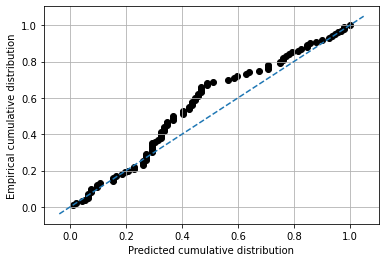

Deep ensemble test calibration error when step size is 0.001:  7.14816257088847
Deep ensemble test calibration error when step size is 0.01:  0.7113705103969756
Deep ensemble test calibration error when step size is 0.1:  0.06932892249527414


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

Concrete dropout test MAPE:  0.099997066


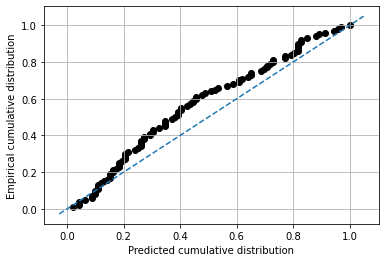

Concrete dropout test calibration error when step size is 0.001:  7.479953686200379
Concrete dropout test calibration error when step size is 0.01:  0.748459357277883
Concrete dropout test calibration error when step size is 0.1:  0.0770085066162571


In [5]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))